In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from scipy import stats
from scipy.stats import iqr
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from joblib import dump


# Import CSV

In [2]:
weather_data = pd.DataFrame(pd.read_csv("data/DataCuaca.csv"))
shallot_production_data = pd.DataFrame(pd.read_csv("data/ProduksiBawangMerah2022.csv"))
shallot_price_data = pd.DataFrame(pd.read_csv("data/HargaBawangMerah2022.csv"))
shallot_price_data['Bulan'] = ['Januari', 'Februari', 'Maret', 'April', 'Mei',
                        'Juni', 'Juli', 'Agustus', 'September', 'Oktober',
                        'November', 'Desember']

# Data Integration

In [3]:
merged_shallot = pd.merge(shallot_production_data, shallot_price_data, on='Bulan', how='inner')
data_shallot = pd.merge(merged_shallot, weather_data, on='Bulan', how='inner')

# Data Selection

In [4]:
df_shallot = data_shallot[['Bulan', 'Produksi', 'Jawa Barat', '2022']].rename(
    columns={
        'Jawa Barat': 'Harga',
        '2022': 'Curah Hujan'
    }
)

# Detect Outlier

In [5]:
fig = px.box(df_shallot, y='Harga')
fig.show()

In [6]:
fig = px.box(df_shallot, y='Curah Hujan')
fig.show()

In [7]:
fig = px.box(df_shallot, y='Produksi')
fig.show()

In [8]:
# Sort the data
data = df_shallot["Harga"].sort_values().reset_index(drop= True)
# Compute the quartiles
n = len(data)
q1 = (data.loc[2] + data.loc[3]) / 2
q3 = (data.loc[8] + data.loc[9]) / 2

IQR = q3 - q1

lower_bound = q1 - (1.5*IQR)
upper_bound = q3 + (1.5*IQR)

outlier = df_shallot[(df_shallot["Harga"] < lower_bound) | (df_shallot["Harga"] > upper_bound)]
if outlier.empty:
    print("Tidak ada outlier")
outlier

,Bulan,Produksi,Harga,Curah Hujan
7,Agustus,24216,50000,384.9


In [9]:
# Sort the data
data = df_shallot["Produksi"].sort_values().reset_index(drop= True)
# Compute the quartiles
n = len(data)
q1 = (data.loc[2] + data.loc[3]) / 2
q3 = (data.loc[8] + data.loc[9]) / 2

IQR = q3 - q1

lower_bound = q1 - (1.5*IQR)
upper_bound = q3 + (1.5*IQR)

outlier = df_shallot[(df_shallot["Produksi"] < lower_bound) | (df_shallot["Produksi"] > upper_bound)]
if outlier.empty:
    print("Tidak ada outlier")
outlier

Tidak ada outlier


,Bulan,Produksi,Harga,Curah Hujan


In [10]:
# Sort the data
data = df_shallot["Curah Hujan"].sort_values().reset_index(drop= True)
# Compute the quartiles
n = len(data)
q1 = (data.loc[2] + data.loc[3]) / 2
q3 = (data.loc[8] + data.loc[9]) / 2

IQR = q3 - q1

lower_bound = q1 - (1.5*IQR)
upper_bound = q3 + (1.5*IQR)

outlier = df_shallot[(df_shallot["Curah Hujan"] < lower_bound) | (df_shallot["Curah Hujan"] > upper_bound)]
if outlier.empty:
    print("Tidak ada outlier")
outlier

Tidak ada outlier


,Bulan,Produksi,Harga,Curah Hujan


### Scalling info

In [11]:
curah_hujan_min = df_shallot["Curah Hujan"].min()
curah_hujan_max = df_shallot["Curah Hujan"].max()
produksi_min = df_shallot["Produksi"].min()
produksi_max = df_shallot["Produksi"].max()

# Save the min and max values to a file
scaling_info = {
    'curah_hujan_min': curah_hujan_min,
    'curah_hujan_max': curah_hujan_max,
    'produksi_min': produksi_min,
    'produksi_max': produksi_max
}

with open("scaling_info_shallot.pkl", "wb") as f:
    pickle.dump(scaling_info, f)

print(scaling_info)

{'curah_hujan_min': 106.6, 'curah_hujan_max': 492.3, 'produksi_min': 8884, 'produksi_max': 50578}


# Binning Outlier

In [12]:
data = df_shallot["Harga"].sort_values().reset_index(drop= True)
data.to_numpy()

split_data = np.array_split(data, 3)
bin1 = split_data[0]
bin2 = split_data[1]
bin3 = split_data[2]

mean_bin1 = round(bin1.mean())
mean_bin2 = round(bin2.mean())
mean_bin3 = round(bin3.mean())

/home/aras/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.



In [13]:
# Binning
df_shallot["Harga"] = df_shallot["Harga"].mask(df_shallot["Harga"] <= bin1[3], mean_bin1)
df_shallot["Harga"] = df_shallot["Harga"].mask((df_shallot["Harga"] > bin1[3]) & (df_shallot["Harga"] < bin3[8]), mean_bin2)
df_shallot["Harga"] = df_shallot["Harga"].mask(df_shallot["Harga"] >= bin3[8], mean_bin3)

In [14]:
fig = px.box(df_shallot, y='Harga')
fig.show()

# Normalize Data

In [15]:
df_shallot["Curah Hujan"] = (df_shallot["Curah Hujan"] - df_shallot["Curah Hujan"].min()) / (df_shallot["Curah Hujan"].max() - df_shallot["Curah Hujan"].min())
df_shallot["Produksi"] = (df_shallot["Produksi"] - df_shallot["Produksi"].min()) / (df_shallot["Produksi"].max() - df_shallot["Produksi"].min())

In [16]:
# Assuming df_shallot is your training dataframe
curah_hujan_min = df_shallot["Curah Hujan"].min()
curah_hujan_max = df_shallot["Curah Hujan"].max()
produksi_min = df_shallot["Produksi"].min()
produksi_max = df_shallot["Produksi"].max()

# Save the min and max values to a file
scaling_info = {
    'curah_hujan_min': curah_hujan_min,
    'curah_hujan_max': curah_hujan_max,
    'produksi_min': produksi_min,
    'produksi_max': produksi_max
}

with open("scaling_info_shallot.pkl", "wb") as f:
    pickle.dump(scaling_info, f)

# Correlation

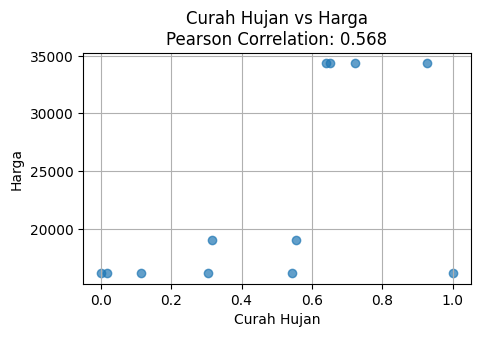

In [17]:
# Correlation between Curah Hujan and Harga
corr, _ = pearsonr(df_shallot["Curah Hujan"], df_shallot["Harga"])

# Visualization of the correlation
plt.figure(figsize=(5, 3))
plt.scatter(df_shallot["Curah Hujan"], df_shallot["Harga"], alpha=0.7)
plt.title(f'Curah Hujan vs Harga\nPearson Correlation: {corr:.3f}')
plt.xlabel('Curah Hujan')
plt.ylabel('Harga')
plt.grid(True)

# Show the plot
plt.show()

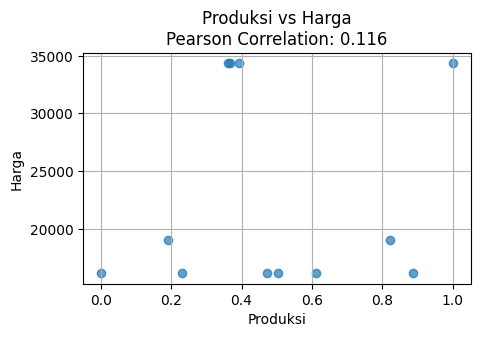

In [18]:
# Correlation between Produksi and Harga
corr, _ = pearsonr(df_shallot["Produksi"], df_shallot["Harga"])

# # Visualization of the correlation
plt.figure(figsize=(5, 3))
plt.scatter(df_shallot["Produksi"], df_shallot["Harga"], alpha=0.7)
plt.title(f'Produksi vs Harga\nPearson Correlation: {corr:.3f}')
plt.xlabel('Produksi')
plt.ylabel('Harga')
plt.grid(True)

# Show the plot
plt.show()

# Prediction

In [19]:
X = df_shallot[["Curah Hujan", "Produksi"]]
y = df_shallot["Harga"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Evaluate Model

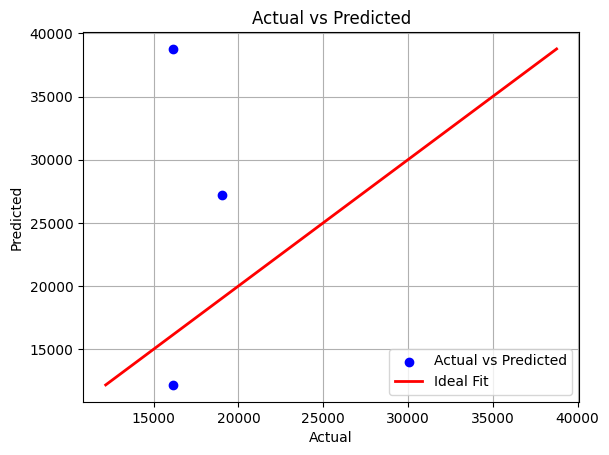

In [21]:
# Tentukan rentang untuk garis ideal fit
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

# Buat scatter plot
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Ideal Fit')

# Tambahkan label dan judul
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()

In [22]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

14070.885348974896

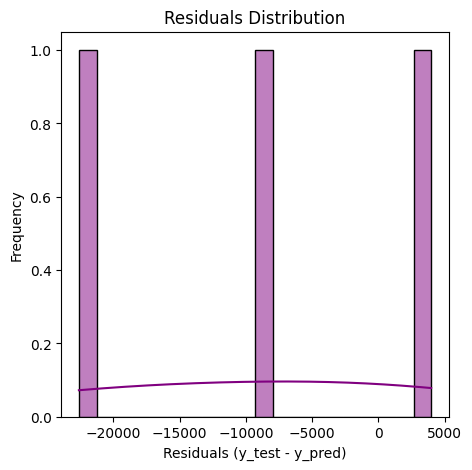

In [23]:
residuals = y_test - y_pred
plt.figure(figsize=(5, 5))
sns.histplot(residuals, bins=20, kde=True, color='purple')
plt.xlabel('Residuals (y_test - y_pred)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

In [24]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

<Figure size 640x480 with 0 Axes>

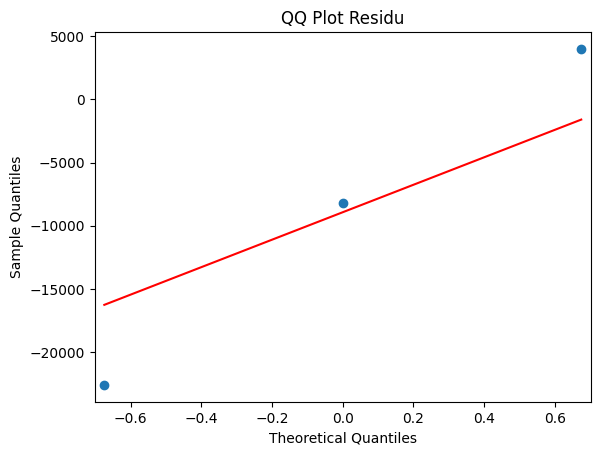

In [25]:
residuals = y_test - y_pred

plt.figure()
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Residu')
plt.show()

In [26]:
with open('shallot', 'wb') as files:
    pickle.dump(regressor, files)

In [27]:
dump(regressor, 'prediction.joblib')

# Simpan model ke dalam file
with open('shallot.pkl', 'wb') as f:
    pickle.dump(regressor, f)